In [ ]:
!conda install -c conda-forge openh264
!conda install -c conda-forge ffmpeg

In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import animation
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
import webbrowser
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
def createForest(L, d):
    # Creating forest with LxL dimension and density d
    grid = np.random.random((L, L))
    grid[grid <= d] = 1
    grid[grid != 1] = 0
    grid = grid.astype('int')
    return grid

In [3]:
def setFire(grid, i, j):
    L = len(grid)
    more_trees = []
    x = max(0, i - 1)
    
    while x <= min(i + 1, L - 1):
        y = max(0, j-1)
        
        while y <= min(j + 1, L - 1):
            
                if(x != i or y != j):
                    
                    if(grid[x, y] == 1):
                            grid[x, y] = 2
                            more_trees = more_trees+[[x, y]]
                            
                y = y + 1
                
        x = x + 1
    return {'grid': grid, 'more_trees': more_trees}
         

In [4]:
def simulateFire(grid):
    # Initializing
    fig = plt.figure(figsize = (10, 10))
    ims = []
    L = len(grid)
    
    empty_before = (grid == 0).sum() # cells unoccupied before burning
    print("% Occupied before fire:", round((grid == 1).sum()*100/(L*L),1),"%")
    
    # Setting left edge on Fire
    grid[grid[:, 0] == 1, 0] = 2
    
    # Setting right edge on fire
    # grid[grid[:, L - 1] == 1, 0] = 2
    
    # Setting top edge on fire
    # grid[grid[0, :] == 1, 0] = 2
    
    # Setting bottom edge on fire
    # grid[grid[L - 1, :] == 1, 0] = 2
    
    
    old_burning_trees = np.transpose(np.where(grid == 2)).tolist()
    new_burning_trees = []
    
    # Spreading Fire
    print("Burning!")
    while(old_burning_trees != []):        
        im = gridShow(grid)
        ims.append([im])
        
        for cell in old_burning_trees:           
            i = cell[0]
            j = cell[1]
            
            if(grid[i, j] == 2):
                result = setFire(grid, i, j)
                grid[i, j] = 0
                grid = result['grid']
                new_burning_trees = new_burning_trees + result['more_trees']
                
        old_burning_trees = new_burning_trees
        new_burning_trees = []
    
    print("Done!")
    
    # Calculating %burnt
    empty_after = (grid == 0).sum()
    print("% Occupied after fire:", round((grid == 1).sum()*100/(L*L),1),"%")
    per_burnt = round((empty_after - empty_before)*100/(L*L),1)
    print("% Burnt: ", per_burnt,"%")
    
    # Creating Animation
    ani = animation.ArtistAnimation(fig, ims, interval = 50, blit  = True)
    url = "Forest.html"
    ani.save(url)
    new = 2 # open in a new tab, if possible
    webbrowser.open(url, new = new)
    print("Please view animation in browser new tab called 'Forest.html'")

In [5]:
def gridShow(grid):
    colors = ['black', 'green', 'orange']
    cmap = matplotlib.colors.ListedColormap(colors)
    fig = plt.imshow(grid, cmap = cmap, animated = True)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    return fig

In [6]:
def findClusters(grid):
    L = len(grid)
    label_matrix = np.zeros((L, L)).astype('int')
    label_no = 1
    
    # Using Hoshen-Kopelman Algorithm
    for j in range(L):
        
        for i in range(L):
            
            if(grid[i, j] == 1):
                up_left = label_matrix[max(i - 1, 0),max(j - 1, 0)]
                left = label_matrix[i, max(j - 1,0)]
                down_left = label_matrix[min(i + 1, L - 1), max(j - 1, 0)]
                up = label_matrix[max(i - 1, 0), j]
                check_labels  = np.array([left, up_left, down_left, up])
                
                if(sum(check_labels) == 0): 
                    curr = label_no
                    label_no = label_no + 1
                    
                elif(sum(check_labels) == max(check_labels)):
                    curr = max(check_labels)
                    
                else:
                    union_label = min(check_labels[check_labels != 0])
                    curr = union_label
                    
                    if(down_left != 0):
                        label_matrix[label_matrix == down_left] = union_label
                        
                    if(up_left != 0):
                        label_matrix[label_matrix == up_left] = union_label
                        
                    if(left != 0):
                        label_matrix[label_matrix == left] = union_label
                        
                    if(up != 0):
                        label_matrix[label_matrix == up] = union_label
                        
                label_matrix[i, j] = curr
                
    #Re-assigning cluster numbers in order              
    assigned_clusters = np.unique(label_matrix)
    for i in range(len(assigned_clusters)):
        label_matrix[label_matrix==assigned_clusters[i]]=i 
    
    return(label_matrix)

In [7]:
def percolationThreshold(L, d):
    n = 100
    percolation_threshold = 0
    for i in range(n):
        success = 0
        
        # Generating random grid
        grid = createForest(L, d)

        # Getting clusters in grid
        label_matrix = findClusters(grid)
        clusters = np.unique(label_matrix)
        
        # Cluster 0 is unoccupied cells
        clusters = clusters[clusters != 0]
        
        # Checking if any cluster spans from left edge to right
        for k in clusters:
            
            if(k in label_matrix[:, 0] and k in label_matrix[:, L - 1]):
                success = 1
                
        if(success == 1):
            percolation_threshold = percolation_threshold + 1/n
            
    return round(percolation_threshold, 2)

In [8]:
def largestCluster(L, d):
# Finding average size of largest cluster for L, d
    n = 100 # no. of trials
    
    avg=0
    for i in range(n):
        grid = createForest(L, d)
        label_matrix = findClusters(grid)
        
        clusters = np.unique(label_matrix)
        
        # Cluster 0 is unoccupied cells
        clusters = clusters[clusters != 0]
        
        big = 0   # size of biggest cluster
        for k in clusters:
            curr = (label_matrix==k).sum() #Finding size of current cluster
            if(curr > big):
                big = curr
        avg = avg + big/n
        
    return round(avg,2)

Forest dimension:  100
Forest density:  0.4
Forest Created!
% Occupied before fire: 40.4 %
Burning!
Done!
% Occupied after fire: 29.2 %
% Burnt:  11.2 %


MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .html

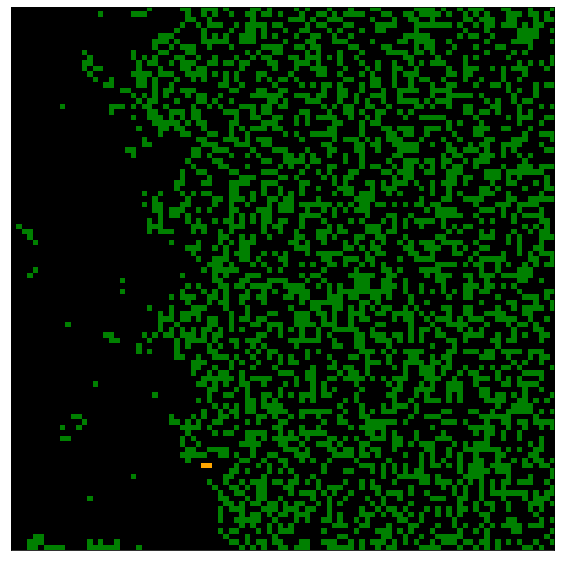

In [10]:
if __name__=='__main__':
    # Opens a HTML file 
    # This file contains blah blah
    # Animation for L=100, d=0.6 #Label Matrix for L,d
    # Graph of Percolation Thresholds for L=20,50,100
    
    d = 0.4 # Density of Forest   
    L = 100 # Dimension of Forest
    
    print("Forest dimension: ", L)
    print("Forest density: ", d)
    
    # Creating Forest, Simulating Fire:
    grid = createForest(L, d)
    print("Forest Created!")
    simulateFire(grid)
    
    # label_matrix = findClusters(grid)
    # print(label_matrix)
    # fig = plt.imshow(label_matrix, cmap = plt.get_cmap('tab10')) # This is not perfect
    
    
    # Average size of Largest Cluster
    print("Average size of largest cluster: ",largestCluster(L,d))
       
    # Percolation Threshold for L, d
    print("Percolation Threshold: ", percolationThreshold(L, d))
    
    # Birthday: 20/07 L = 10*7 p* = 20/32
    print("Density of Forest when L = 70 and required threshold is 0.625")
    n = 100 #no of trials
    p_t = np.zeros(n) # Array of Percolation Thresholds
    for i in range(n):
        p_t[i] = percolationThreshold(L,i/n)
        if(p_t[i] >= 20/32):
            print("d = ", i/n)
            break
            
    # Plotting p vs. average size of largest cluster for L = 100
    n = 10
    d = np.linspace(0,1,n)
    avg = np.zeros(n)
    for i in range(n):
        avg[i] = largestCluster(L,d[i]) 
    tck = interpolate.splrep(d, avg, s=0)
    xnew = np.arange(0, 1, 0.001)
    ynew = interpolate.splev(xnew, tck, der=0)
    plt.figure()
    plt.plot(d, avg, 'o', xnew, ynew, '-')
    plt.xlabel('density of forest')
    plt.ylabel('Avg. size of Largest Cluster')
    plt.legend(['Observed', 'Interpolation'])
    plt.title('Average Largest Cluster size vs. density for L = 100')